# Efecto de régimen de dosificación en PTA

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from keras.wrappers.scikit_learn import KerasRegressor

import plotly.express as px
import plotly.graph_objects as go

import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets

import eli5
from eli5.sklearn import PermutationImportance
import shap

In [2]:
data = pd.read_csv('datosFunRenal.csv')
data.head()

,Tipo,MIC,mn,g,CLCR,DD,ii,tinf
0,1,0.062500,1.0,1,90,15.0,6,2
1,1,0.067033,1.0,1,90,15.0,6,2
2,1,0.071894,1.0,1,90,15.0,6,2
3,1,0.077108,1.0,1,90,15.0,6,2
4,1,0.082701,1.0,1,90,15.0,6,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tipo    21000 non-null  int64  
 1   MIC     21000 non-null  float64
 2   mn      21000 non-null  float64
 3   g       21000 non-null  int64  
 4   CLCR    21000 non-null  int64  
 5   DD      21000 non-null  float64
 6   ii      21000 non-null  int64  
 7   tinf    21000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 1.3 MB


Se seleccionan a las variables `DD`, `ii`, `tinf`, `CLCR`, y `MIC`, como variables dependientes, se conoce por gráficos marginales que `ii`, `tinf`, y `CLCR` aportan poca información sobre el indicador PK-PD reportado en la columna `mn` (AUC/MIC >= 400).

In [4]:
X = data.loc[:, ['DD', 'ii', 'tinf', 'CLCR', 'MIC']]
X.MIC = np.log2(X.MIC) # Se convierte a logaritmo por simplicidad
y = data.mn

In [5]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

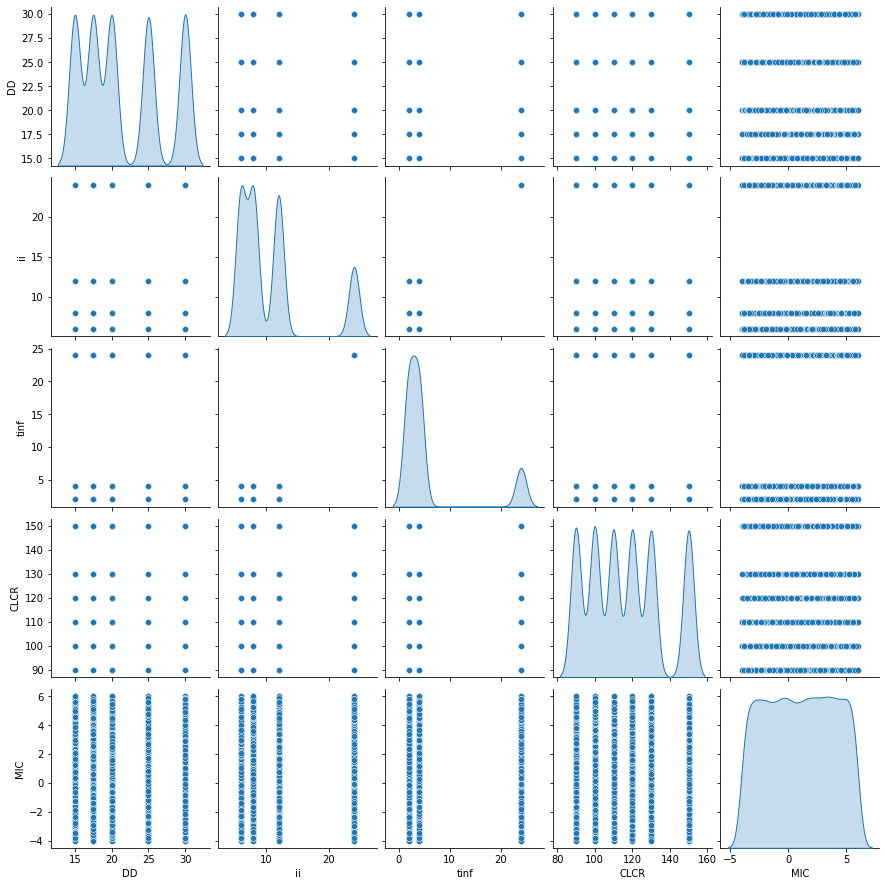

In [7]:
sns.pairplot(X_train, diag_kind='kde');

## Modelo
Ahora se especifica la configuración de la red neuronal artificial, mediante la librería `Keras`.

In [8]:
def regresorKeras():
  # Inicio de modelo
  model = tf.keras.models.Sequential([normalizer])
  # Capa de entrada
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X_train.shape[1],)))
  # Capas ocultas
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
  # Capa de salida
  # Se selecciona sólo una neurona de salida: sólo hay un indicador: AUC/MIC > 400
  # La capa de salida sólo permite valores de 0 a 1 se usa fun sigmoidea
  model.add(tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)) 

  model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = 'mean_absolute_error')
  return model; 

In [9]:
regresorKeras().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 10)                60        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 302
Trainable params: 291
Non-trainable params: 11
_________________________________________________________________


In [10]:
estimator = KerasRegressor(build_fn=regresorKeras, 
                           batch_size=32, epochs=60, 
                           validation_data=(X_test.values, y_test.values),
                           verbose=0)

history = estimator.fit(X_train.values, y_train.values)

In [11]:
histDF = pd.DataFrame(history.history)
histDF['epoch'] = history.epoch
histDF.tail()

,loss,val_loss,epoch
55,0.002988,0.004614,55
56,0.002458,0.003284,56
57,0.002596,0.003535,57
58,0.002763,0.003771,58
59,0.002643,0.003075,59


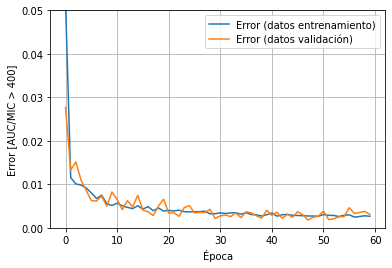

In [12]:
plt.plot(history.history['loss'], label='Error (datos entrenamiento)')
plt.plot(history.history['val_loss'], label='Error (datos validación)')
plt.ylim([0, 0.05])
plt.xlabel('Época')
plt.ylabel('Error [AUC/MIC > 400]')
plt.legend()
plt.grid(True)
plt.savefig('./004_Error_Enternamiento.pdf')

In [13]:
def expand_grid(x, y, xval = 'x', yval = 'y'):
    xG, yG = np.meshgrid(x, y) # Crear malla
    xG = xG.flatten() # Hacer malla 1D
    yG = yG.flatten() # Igual
    return pd.DataFrame({xval:xG, yval:yG})

sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(15, 30), xval = 'MIC', yval = 'DD')
sampleDF['ii'] = 6
sampleDF['tinf'] = 2
sampleDF['CLCR'] = 120
sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [14]:
x = np.linspace(-6, 6)
y = np.linspace(15, 30)
z = estimator.predict(sampleDF)

In [15]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 15, "end": 30, "size": 5, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = x,
    y = y,
    z = z.reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, x)],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>DD</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = ['rgb(0,0,255)', 'rgb(255,0,0)'],
    surfacecolor = np.array(["1" if i >= 0.85 else "0" for i in z]).reshape((50, 50))
    # %{custom_data[0]:.2f}
    ))

fig.update_layout(
    title='Superficie de respuesta ANN',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log2(PTA)",
        "yaxis_title": "Dosis diaria <br> (mg/kg/dia)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("005_superficiePTA_dosis_MIC.html")


In [16]:
cdict = {'red':   [(0.0000,  1,1),
                   (0.8499,  1,1),
                   (0.8501,  0, 0),
                   (1.0000,  0, 0)],
         
         'green': [(0.0000,  0.0, 0.0),
                   (0.8499,  0.0, 0.0),
                   (0.8501,  0.988, 0.988),
                   (1.0000,  0.988, 0.988)],
         
         'blue':  [(0.0000,  0.0, 0.0),
                   (0.8499,  0.0, 0.0),
                   (0.8501,  0.114, 0.114),
                   (1.0000,  0.114, 0.114)]}

newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

In [17]:
def grafico3DSuperficie(x, y, z, newcmp, xlab = '', ylab = '', zlab = '', 
                        lim_opt = {'xlab': [-6, +6], 'ylab': [15,30], 'zlab': [0,1]}, 
                        view_init_opt = {'elev': 10, 'azim': 12}):
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  
  x1, y1 = np.meshgrid(x, y)

  ax.plot_surface(x1, y1, z, cmap=newcmp, linewidth=0, antialiased=False)
  ax.set_xlim(lim_opt['xlab'][0], lim_opt['xlab'][1])
  ax.set_ylim(lim_opt['ylab'][0], lim_opt['ylab'][1])
  ax.set_zlim(lim_opt['zlab'][0], lim_opt['zlab'][1])
  ax.set_xlabel(xlab)
  ax.set_ylabel(ylab)
  ax.set_zlabel(zlab)
  ax.view_init(elev = view_init_opt['elev'], azim = view_init_opt['azim']);
  return fig;

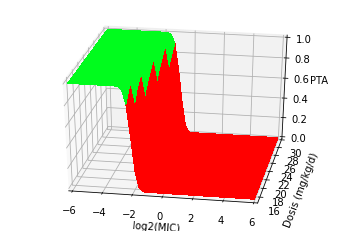

In [18]:
fig = grafico3DSuperficie(x, y, z.reshape((50, 50)), newcmp, 'log2(MIC)', 'Dosis (mg/kg/d)', 'PTA', 
                          view_init_opt = {'elev': 30, 'azim': 270+10})
plt.savefig('006_superficiePTA_dosis_MIC.pdf')

## Relación de MIC y CLCR
Se evalúo la relación para CLCR frente a MIC; 

In [19]:
sampleDF = expand_grid(np.linspace(-6, 6), np.linspace(90, 150), xval = 'MIC', yval = 'CLCR')
sampleDF['ii']   = 6
sampleDF['tinf'] = 2
sampleDF['DD']   = 20
sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

In [20]:
x = np.linspace(-6, 6)
y = np.linspace(90, 150)
z = estimator.predict(sampleDF)

In [21]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": -6, "end": +6, "size": 1, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = x,
    y = y,
    z = z.reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, x)],
    hovertemplate = '<b>MIC</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = ['rgb(0,0,255)', 'rgb(255,0,0)'],
    surfacecolor = np.array(["1" if i >= 0.85 else "0" for i in z]).reshape((50, 50))
    # %{custom_data[0]:.2f}
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - PTA vs CLCR',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "log2(PTA)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("007_superficiePTA_CLCR_MIC.html")

## Relación de Dosis y CLCR a MIC = 0.0625

In [22]:
sampleDF = expand_grid(np.linspace(15, 30), np.linspace(90, 150), xval = 'DD', yval = 'CLCR')
sampleDF['ii'] = 6
sampleDF['tinf'] = 2
sampleDF['MIC'] = 2^-4
sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

x = np.linspace(15, 30)
y = np.linspace(90, 150)
z = estimator.predict(sampleDF)

In [23]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 15, "end": 30, "size": 1, "color":"white"},
        "y": {"show": True, "start": 90, "end": 150, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = x,
    y = y,
    z = z.reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, x)],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>CLCR</b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = ['rgb(0,0,255)', 'rgb(255,0,0)'],
    surfacecolor = np.array(["1" if i >= 0.85 else "0" for i in z]).reshape((50, 50))
    # %{custom_data[0]:.2f}
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Dosis vs CLCR - MIC: 0.0625',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "Dosis (mg/kg/d)",
        "yaxis_title": "CLCR <br> (mL/min)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("008_superficiePTA_CLCR_Dosis.html")

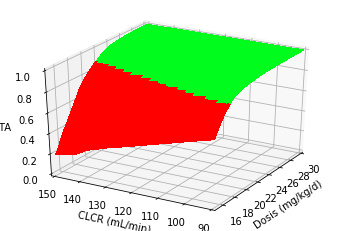

In [24]:
fig = grafico3DSuperficie(x, y, z.reshape((50, 50)), newcmp, 'Dosis (mg/kg/d)', 'CLCR (mL/min)', 'PTA', 
                          lim_opt = {'xlab': [15, 30], 'ylab': [90, 150], 'zlab': [0,1]}, 
                          view_init_opt = {'elev': 30, 'azim': 180+30})
plt.savefig('009_superficiePTA_CLCR_Dosis.pdf')

## Relación de Dosis y Tiempo de infusión a MIC = 0.125

In [25]:
sampleDF = expand_grid(np.linspace(15, 30), np.linspace(2, 24), xval = 'DD', yval = 'tinf')
sampleDF['ii']   = 24
sampleDF['CLCR'] = 120
sampleDF['MIC']  = 2^-4
sampleDF = sampleDF[['DD', 'ii', 'tinf', 'CLCR', 'MIC']]

x = np.linspace(15, 30)
y = np.linspace(2, 24)
z = estimator.predict(sampleDF)

In [26]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": 15, "end": 30, "size": 1, "color":"white"},
        "y": {"show": True, "start": 2, "end": 24, "size": 10, "color":"white"},
        "z": {"show": True, "start": 0, "end": 1, "size": 0.1}
    },
    x = x,
    y = y,
    z = z.reshape((50, 50)), 
    customdata = [i for i in map(lambda m: 2**m, x)],
    hovertemplate = '<b>Dosis</b>: %{x:.2f} <br><b>T<sub>inf</sub></b>: %{y} <br><b>PTA</b>: %{z:.2f}<br>',
    colorscale = ['rgb(0,0,255)', 'rgb(255,0,0)'],
    surfacecolor = np.array(["1" if i >= 0.85 else "0" for i in z]).reshape((50, 50))
    # %{custom_data[0]:.2f}
    ))

fig.update_layout(
    title='Superficie de respuesta ANN - Dosis vs T<sub>inf</sub> - MIC: 0.0625 - CLCR: 120mL/min - II: 24h',
    scene = {
        "xaxis": {"nticks": 6},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.5},
        "xaxis_title": "Dosis (mg/kg/d)",
        "yaxis_title": "T<sub>inf</sub> <br> (hrs)",
        "zaxis_title": "PTA <br> (AUC/MIC > 400)"
        })
fig.show()

fig.write_html("010_superficiePTA_Dosis_TINF.html")

## Explicación de importancia de predictores

In [27]:
perm = PermutationImportance(estimator, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



Weight,Feature
0.3636 ± 0.0045,MIC
0.0387 ± 0.0015,DD
0.0100 ± 0.0003,CLCR
0.0005 ± 0.0001,tinf
0.0004 ± 0.0001,ii


In [28]:
def f_wrapper(X):
    return estimator.predict(X).flatten()

X_train_summary = shap.kmeans(X_train, 20)

explainer = shap.KernelExplainer(f_wrapper, X_train_summary)

# Make plot with combined shap values
# The training set is too big so let's sample it. We get enough point to draw conclusions
X_train_sample = X_train.sample(400)
shap_values  = explainer.shap_values(X_train_sample)

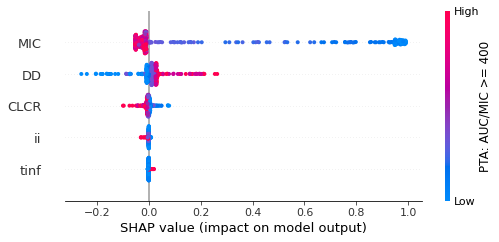

In [33]:
shap.summary_plot(shap_values, X_train_sample, 
                  color_bar_label='PTA: AUC/MIC >= 400', title = 'Impacto de predictores en PTA', show = False)

plt.gcf()
plt.savefig('011_shapValuesPTA_AUCMIC.pdf')

In [30]:
shap.plots.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

In [31]:
shap.plots.initjs()
shap.plots.force(explainer.expected_value, shap_values, X_train_sample,
                 feature_names=['DD', 'ii', 'tinf', 'CLCR', 'MIC'])